# PROJETO 4 - AUTOENCODER

## Objetivos

Esse projeto teve como principais objetivos:

* Implementar um autoencoder;
* Testa-lo nos datasets MNIST e Fashion MNIST;
* Variar o número de neurônios internos e o número de camadas;
* Visualizar a codificação gerada pelos neurônios da primeira camada oculta

## Metodologia

Nessa secção será detalhada a metodologia experimental utilizada para alcançar os objetivos anteriormente mencionados.

#### Bibliotecas Utilizadas
Foi utilizada a linguagem de programação Python 3 para realizar a implementação dos experimentos. Para a criação da rede neural, e tratamento dos dados foi utilizada a biblioteca Pytorch, e para a visualizar os dados, foi utilizada as bibliotecas matplotlib e pandas. O trecho de código a seguir mostra todas as bibliotecas utilizadas.

In [9]:
import torch
from torch import nn
from torch.nn import functional
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

from torchsummary import summary

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#### Datasets

Foram realizados experimentos com dois datasets, ambos disponiveis na bibliteca Pytorch:

* **MNIST:** Dataset de digitos escritos a mão. Possui 60000 exemplos de treinamento e 10000 para teste/validação, que tomam forma de imagens monocromaticas com resolução de 28x28 pixels. Disponivel para download em <a href="https://www.it-swarm.net/pt/jupyter/realcar-erros-de-digitacao-na-marcacao-jupyter-do-notebook/826521767/" target="_blank">https://www.it-swarm.net/pt/jupyter/realcar-erros-de-digitacao-na-marcacao-jupyter-do-notebook/826521767/</a>.


* **Fashion MNIST:** Dataset com 10 classes de peças de roupas, feito para poder ser utilizado como um substituto direto do MNIST, posuindo a mesma quantidade de classes, exemplos e e rosolução de imagem. Disponivel para download em  <a href="https://github.com/zalandoresearch/fashion-mnist" target="_blank">https://github.com/zalandoresearch/fashion-mnist</a>.

#### Normalização dos Datasets

Para a realização dos demais experimentos, inicialmente foi necessário realizar a normalização dos datasets. Para realizar essa tarefa é calculado a média e desvio padrão para cada dataset, como pode ser visto no código abaixo. 

In [10]:
def dataset_mean_std( dataset ):
    loader = torch.utils.data.DataLoader(dataset,
                             batch_size=1,
                             num_workers=4,
                             shuffle=False)

    mean = 0.
    std = 0.
    with tqdm(total=len(loader.dataset), ascii=True, desc='calculating mean and std') as pbar:
        for image, _ in loader:
            mean += torch.mean(image)
            std += torch.std(image)
            pbar.update(1)

    mean /= len(loader.dataset)
    std /= len(loader.dataset)
    return mean, std

In [11]:
mnist   = datasets.MNIST(root='./datasets', train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
f_mnist = datasets.FashionMNIST(root='./datasets', train=True, transform=transforms.ToTensor(), target_transform=None, download=True)

In [12]:
mnist_mean, mnist_std   = dataset_mean_std(mnist)

calculating mean and std: 100%|##########| 60000/60000 [01:10<00:00, 855.04it/s]


In [13]:
f_mnist_mean, f_mnist_std = dataset_mean_std(f_mnist)

calculating mean and std: 100%|##########| 60000/60000 [01:08<00:00, 879.62it/s]


In [14]:
print('mnist mean:', mnist_mean, 'mnist std:', mnist_std)
print('fashion mnist mean:', f_mnist_mean, 'fashion mnist std:', f_mnist_std)

mnist mean: tensor(0.1307) mnist std: tensor(0.3015)
fashion mnist mean: tensor(0.2860) fashion mnist std: tensor(0.3205)


Com os valores da média e devio padrão, a normalização dos dados é realizada utilizando a função `transforms.Normalize(mean, std)`, que realiza a seguinte operação:

\begin{equation*}
image = (image - mean)/std
\end{equation*}

In [15]:
mnist_transform   = transforms.Compose([transforms.ToTensor(), transforms.Normalize( (mnist_mean,)  , (mnist_std,)   )])
f_mnist_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize( (f_mnist_mean,), (f_mnist_std,) )])

Essa função é utilizada como argumento para um objeto da classe DataLoader, que carrega exemplos de um dataset, e aplica essa função a eles antes de retorna-los.

No código abaixo são os datasets MNIST e Fashion MNIST são carregados por meio de DataLoaders.

In [16]:
mnist_train = datasets.MNIST(root='./datasets', train=True,  transform=mnist_transform, target_transform=None, download=True)
mnist_val   = datasets.MNIST(root='./datasets', train=False, transform=mnist_transform, target_transform=None, download=True)

f_mnist_train = datasets.FashionMNIST(root='./datasets', train=True,  transform=f_mnist_transform, target_transform=None, download=True)
f_mnist_val   = datasets.FashionMNIST(root='./datasets', train=False, transform=f_mnist_transform, target_transform=None, download=True)

In [17]:
loader_mnist_train = torch.utils.data.DataLoader(mnist_train, batch_size=128, shuffle=True, num_workers=4)
loader_mnist_val   = torch.utils.data.DataLoader(mnist_val  , batch_size=1,   shuffle=True, num_workers=4)

loader_f_mnist_train = torch.utils.data.DataLoader(f_mnist_train, batch_size=128, shuffle=True, num_workers=4)
loader_f_mnist_val   = torch.utils.data.DataLoader(f_mnist_val  , batch_size=1,   shuffle=True, num_workers=4)

#### Implementação do Autoencoder

Foi inplementado um autoencoder na forma de uma classe, cuja a inicialização possui os seguintes parametros:

* **input_size:** Tamanho dos exemplos de entrada da rede, por padrão, definido como 784, o tamanho dos exemplos da base de dados MNIST e Fashion MNIST quando convertidas para um vetor unidimencional.

* **layers_size:** Uma lista que indica a quantidade de neurónios de cada camada do encoder e decoder da rede, de forma que o autoencoder criado por essa classe terá o dobro da quantidade de camadas especificadas. Ex:   layers_size = [128,64,32], camadas do encoder = [128,64,32], camadas do decoder = [64, 128, 784]. Valor padrão = [128]

* **linear:** Indica se serão utilizados apenas camadas lineares no autoencoder. Caso Verdadeiro, são utilizadas apenas camadas densas, sem função de ativação. Caso Falso, as camadas densas são seguidas da função de ativação ReLu, com exeção da ultima camada, que é seguida da função de ativação Sigmoid. Valor padrão = False

O código abaixo mostra a inicialização da classe.


In [18]:
class Autoencoder(nn.Module):
    def __init__(self, input_size = 784,  layers_size = [ 128 ], linear=False ):
        super(Autoencoder,self).__init__()
        self.encoder = []
        self.decoder = []
        self.input_size = input_size
        self.layers_size = layers_size
        self.layers_size = [ input_size ] + self.layers_size
        
        for i in range(0,len(self.layers_size)-1 ):
            if linear:
                block = nn.Linear(self.layers_size[i], self.layers_size[i+1])
            else:
                block = nn.Sequential(nn.Linear(self.layers_size[i], self.layers_size[i+1]), nn.ReLU(True))
            self.encoder += [ block.cuda() ]

        for i in range(0,len(self.layers_size)-2):
            if linear:
                block = nn.Linear(self.layers_size[-1-i], self.layers_size[-1-(i+1)])
            else:
                block = nn.Sequential(nn.Linear(self.layers_size[-1-i], self.layers_size[-1-(i+1)]), nn.ReLU(True))            
            self.decoder += [ block.cuda() ]
        if linear:
            block = nn.Linear(self.layers_size[1], self.layers_size[0])
        else:
            block = nn.Sequential(nn.Linear(self.layers_size[1], self.layers_size[0]), nn.Sigmoid())
        self.decoder += [ block.cuda() ]
                
        self.encoder = nn.ModuleList(self.encoder)
        self.decoder = nn.ModuleList(self.decoder)

O método *foward* indica como é realizada a passada para frente dos dados pela rede, onde no autoencoder criado, a entrada é convertida um vertor de uma dimensão, e então é passada por todas as camadas da rede.

In [19]:
def forward(self,x):
    shape = x.shape
    x = torch.flatten(x, 1).cuda()
    for i in range(len(self.layers_size)-1):
        x = self.encoder[i](x)
    for i in range(len(self.layers_size)-1):
        x = self.decoder[i](x)
    x = torch.reshape(x, shape)
    return x
Autoencoder.forward = forward

O método train realiza o treinamento do rede, tendo os seguintes parametros como entrada:

* **loader:** Um objeto da classe DataLoader do Pytorch que carregue os exemplos de treinamento do dataset desejado;

* **loader_eval:** Um objeto da classe DataLoader do Pytorch que carregue os exemplos de validação do dataset desejado;
    
* **epochs:** Quantidade de épocas que serão executadas, ou seja, a quantidade de vezes na qual todos os exemplos do dataset serão apresentados a rede. Valor padrão = 50;

* **eval_freq:** Quantidade de eṕocas entre as quais o modelo tem seu desempenho avaliado no conjunto de validação. Valor padrão = 10.

Foi utilizado o otimizador Adam, com taxa de aprendizado de 0,001 e constante da penalidade L2 de 0,00001 (weight_decay). É utilizada a função de perda do Erro Quadrático Médio, medindo a diferença entre a imagem gerada pelo autoencoder e a imagem de entrada.

O método retorna listas com o erro quadrático médio para cada época durante o treino e a validação.

In [20]:
def train(self, loader, loader_eval, epochs=50, eval_freq = 10):
    log_loss = []
    log_loss_val = []
    optimizer = torch.optim.Adam(self.parameters(), weight_decay=1e-5)
    distance = nn.MSELoss()
    with tqdm(total=epochs, ascii=True, desc='epoch: 0 loss: None') as pbar:
        i = 1
        for epoch in range(epochs):
            epoch_loss = []
            epoch_val  = []  
            for data in loader:
                img, _ = data
                img = Variable(img).cuda()

                output = self(img)
                loss = distance(output, img)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += [ float(loss.data) ]    
            if i%eval_freq==0:
                loss_val = self.eval(loader_eval, nn.MSELoss())
                log_loss_val += [ loss_val ]
                print('validation loss:', loss_val)
            log_loss += [ np.mean(epoch_loss) ]
            i+=1
            pbar.update(1)
            pbar.set_description_str(desc='epoch:' + str(epoch+1) + ' loss:' + str(float(loss.data)) )
    return log_loss, log_loss_val
Autoencoder.train = train

O método *eval* tem como entrada um DataLoader e uma métrica de distância. Os exemplos contidos no DataLoader são passados pela rede, sendo calculado e retornado a função de distancia informada média entre as entradas e a saida da rede. Usado para realizar a validação da rede. 

In [21]:
def eval(self, loader, distance):
    log_loss = []
    for data in loader:
        img, _ = data
        img = Variable(img).cuda()

        output = self(img)
        loss = distance(output, img)
        log_loss += [ float(loss) ]
    return np.mean(log_loss)
Autoencoder.eval = eval

#### Otimização dos Parametros

A busca dos parametros ótimos é feita por meio de Grid Search, que avalia redes com cada um dos parametros forneceido a ela. Na implementação desse trabalhos, são otimizados os parametros da quantidade de camadas e a quantidade de neuronios em cada camada.

In [22]:
def grid_search(params, train_loader, val_loader, epochs=50, eval_freq = 10, linear=False):
    outputs = {
        'layers_size' : params,    
        'loss_train': [],
        'loss_val': [],
        'loss_val_std': [],
        'loss_': [],
        'loss_val_': [],
        'best_loss': 1000
    }
    
    models = []
    best_model = None
    
    for p in params:
        print('training with ', p , ' layers')
        model = Autoencoder(input_size=784,  layers_size=p, linear=linear).cuda()
        loss, loss_val = model.train(train_loader, val_loader, epochs=epochs, eval_freq=eval_freq)
        outputs['loss_train'] += [loss[-1]]
        outputs['loss_val']   += [loss_val[-1]]
        outputs['loss_']      += [loss]
        outputs['loss_val_']  += [loss_val]
        models += [model]

        if outputs['best_loss'] > loss_val[-1]:
            best_model = model
            outputs['best_loss']  = loss_val[-1]
    return outputs, models, best_model   

In [23]:
def gs_to_dataframes(gs):
    dict_final = {
        'layers_size' : gs['layers_size'],    
        'loss_train': gs['loss_train'],
        'loss_val': gs['loss_val']
    }
    final_results = pd.DataFrame.from_dict(dict_final)
    
    models_results = []
    for i in range(len(gs['loss_'])):
        m_dict = {
             'epochs' : list( range( len(gs['loss_'][i]) ) ),
            'loss_train': gs['loss_'][i],
            'loss_val': []
        }
        
        eval_freq = int( len(gs['loss_'][i]) / len(gs['loss_val_'][i])    )
        last_value = float('nan')
        for value in gs['loss_val_'][i]:
            for j in range(eval_freq - 1):
                m_dict['loss_val'] += [ last_value ]
            m_dict['loss_val'] += [ value ]
            last_value = value
            
        models_results += [ pd.DataFrame.from_dict(m_dict) ]
        
    return final_results, models_results

A seguir pode ser observado os parametros que foram testados pelo Grid Search nos experimentos realizados nesse trabalho, onde cada elemento da lista indica uma configuração de quantidade de camadas e neurônios da rede.

Exemplo: o elemento 2 da lista, [32,  16], indica uma configuração de rede onde o encoder possue duas camadas, com respectivamente 32 e 16 neurónios cada, e o decoder possue duas camadas, respectivamente, 32 e 784 (tamanho da entrada) neurônios cada.

In [24]:
params = [  [32],  [32,  16], [ 32,  16,  8],
            [64],  [64,  32], [ 64,  32, 16],
           [128], [128,  64], [128,  64, 32] ]

#### Análise dos Resultados

Para realização da analise dos resultados obtidos, são construidos gráficos que apresentão a fução de perda para cada época do terinamento e validação para todos os modelos testados pelo Grid Search, sendo possivel observar a influência da quantidade de camadas e neurónios no desempenho da rede.

In [25]:
def plot_learning_curve(tables, params, colors, param_name, xlim = [0,49], ylim = [0.4, 1]):
    plt.rcParams['figure.figsize'] = [15, 5]
    f, axarr = plt.subplots(1, 2)
    i=0
    train_val = ['treino', 'validação']
   
    for i in range(len(tables)):
        axarr[0].plot(tables[i]['epochs'], tables[i]['loss_train'], color=colors[i], label = param_name+'='+str(params[i]) )
    axarr[0].set_title('Treinamento', fontsize=25)
    axarr[0].set_xlabel('épocas')
    axarr[0].set_ylabel('Perda', fontsize=25)

    for i in range(len(tables)):
        axarr[1].plot(tables[i]['epochs'], tables[i]['loss_val'], color=colors[i], label = param_name+'='+str(params[i]) )
    axarr[1].set_title('Validação', fontsize=25)
    axarr[1].set_xlabel('épocas')

    
    axarr[0].set_xlim( xlim )
    axarr[0].set_ylim( ylim )
    axarr[1].set_xlim( xlim )
    axarr[1].set_ylim( ylim )
    
    f.subplots_adjust(hspace=0.3)

    axarr[0].legend(loc='upper left', bbox_to_anchor=(-0.1, 1.3), ncol=7)

Para realizar uma analise qualitativa dos resultados obtidos, para o mehor modelo obtido pelo Grid Search (o que possuir o menor valor de perda para validação após o treinamento), são mostrados lado a lado, para um exemplo de cada classe da base de dados, a imagem de entrada, a representação gerada pela primeira camada oculta para essa imagem, e a imagem de saída gerada pelo autoencoder.

In [26]:
def plot_examples_autoencoder( loader, model, n=10):
    examples = { }
    sampled = np.zeros(n)
    for img, labels in loader:
        img, labels = next(iter(loader))
        if sampled[ int(labels[0]) ] == 0: 
            sampled [ int(labels[0]) ] = 1
            examples[ int(labels[0]) ] = img
        if np.sum(sampled) == n:
            break
        
    for i in range(n):
        plt.figure(figsize=(20, 4))
        plt.subplot(141)
        plt.title('Imagem de Entrada')
        
        imgs = examples[i]
        img = imgs.reshape([28,28])
        plt.imshow(img, cmap='Greys')


        plt.subplot(142)
        plt.title('Codificação Gerada pela Primeira Camada Oculta')

        first_layer_out = model.encoder[0]( torch.flatten(imgs, 1).cuda() ).data.cpu()
        coded_shape = first_layer_out.data.cpu().shape[-1]
        plt.bar(list(range(coded_shape)), first_layer_out.reshape( [coded_shape] ) )


        plt.subplot(143)
        plt.title('Saida da Rede')

        out = model(imgs.cuda())
        plt.imshow(out.data.cpu().reshape([28,28]), cmap='Greys')
        plt.show()

## Experimentos e Resultados

Os experimentos realizados foram divididos em quatro tipos, sendo eles:

1. Experimentos com o dataset MNIST com Autoencoder que possue camadas não lineares;
2. Experimentos com o dataset Fashion MNIST com Autoencoder que possue camadas não lineares;
3. Experimentos com o dataset MNIST com Autoencoder que possue apenas camadas lineares;
4. Experimentos com o dataset Fashion MNIST com Autoencoder que possue apenas camadas lineares;

Onde para cada tipo, foram realizados a busca pelos parametros ótimos usando o Grid Search, a comparação de todos os modelos testados por meio de um gráfico com a perda para cada época, e por fim a análise da saída resultado da rede ao colocar lado a lado exemplos de entrada, a codificação gerada pela primeira camada e a saida do autoencoder.

O código a seguir mostra a execução do Grid Search para cada um dos tipos de experimento.

In [ ]:
gs_mnist, mnist_models, mnist_best_model = grid_search(params, loader_mnist_train,
                                                               loader_mnist_val, epochs=50)

In [14]:
gs_f_mnist, f_mnist_models, f_mnist_best_model = grid_search(params, loader_f_mnist_train,
                                                                     loader_f_mnist_val, epochs=50)

epoch: 0 loss: None:   0%|          | 0/50 [00:00<?, ?it/s]

training with  [32]  layers


epoch:10 loss:0.6192390322685242:  20%|##        | 10/50 [01:13<06:56, 10.41s/it]

validation loss: 0.6182181355878711


epoch:20 loss:0.6252167224884033:  40%|####      | 20/50 [02:26<05:17, 10.57s/it]

validation loss: 0.6149695333063603


epoch:30 loss:0.5823229551315308:  60%|######    | 30/50 [03:39<03:30, 10.55s/it]

validation loss: 0.6144072159677744


epoch:40 loss:0.6171830892562866:  80%|########  | 40/50 [04:51<01:45, 10.54s/it]

validation loss: 0.6142452457726002


epoch: 0 loss: None:   0%|          | 0/50 [00:00<?, ?it/s]

validation loss: 0.6141048777401448
training with  [32, 16]  layers


epoch:10 loss:0.6491386294364929:  20%|##        | 10/50 [01:16<07:27, 11.18s/it]

validation loss: 0.6410746056511998


epoch:20 loss:0.6333823800086975:  40%|####      | 20/50 [02:32<05:42, 11.41s/it]

validation loss: 0.6351328173294664


epoch:30 loss:0.6243026852607727:  60%|######    | 30/50 [03:48<03:45, 11.26s/it]

validation loss: 0.6326220692589879


epoch:40 loss:0.6527323722839355:  80%|########  | 40/50 [05:03<01:53, 11.33s/it]

validation loss: 0.6312573727548122


epoch: 0 loss: None:   0%|          | 0/50 [00:00<?, ?it/s]

validation loss: 0.6299968790978193
training with  [32, 16, 8]  layers


epoch:10 loss:0.657579243183136:  20%|##        | 10/50 [01:18<07:54, 11.85s/it]

validation loss: 0.6718839175835252


epoch:20 loss:0.6788166761398315:  40%|####      | 20/50 [02:37<06:01, 12.05s/it]

validation loss: 0.6620946960553526


epoch:30 loss:0.6862637400627136:  60%|######    | 30/50 [03:55<04:00, 12.02s/it]

validation loss: 0.6546116114944219


epoch:40 loss:0.6767573356628418:  80%|########  | 40/50 [05:14<02:00, 12.07s/it]

validation loss: 0.6509284997031093


epoch: 0 loss: None:   0%|          | 0/50 [00:00<?, ?it/s]

validation loss: 0.6493346570670605
training with  [64]  layers


epoch:10 loss:0.6114369630813599:  20%|##        | 10/50 [01:12<06:59, 10.49s/it]

validation loss: 0.6011939436674119


epoch:20 loss:0.6093804240226746:  40%|####      | 20/50 [02:25<05:15, 10.52s/it]

validation loss: 0.5984628568023443


epoch:30 loss:0.6500955820083618:  60%|######    | 30/50 [03:38<03:32, 10.63s/it]

validation loss: 0.5980182837978005


epoch:40 loss:0.6048726439476013:  80%|########  | 40/50 [04:51<01:45, 10.57s/it]

validation loss: 0.5977631190568209


epoch: 0 loss: None:   0%|          | 0/50 [00:00<?, ?it/s]

validation loss: 0.5975595081672073
training with  [64, 32]  layers


epoch:10 loss:0.619133472442627:  20%|##        | 10/50 [01:16<07:29, 11.24s/it]

validation loss: 0.6247322286009789


epoch:20 loss:0.6359471678733826:  40%|####      | 20/50 [02:32<05:41, 11.38s/it]

validation loss: 0.6161811556726694


epoch:30 loss:0.6316091418266296:  60%|######    | 30/50 [03:48<03:47, 11.36s/it]

validation loss: 0.6129800485938788


epoch:40 loss:0.6085813641548157:  80%|########  | 40/50 [05:04<01:54, 11.45s/it]

validation loss: 0.6114451009854674


epoch: 0 loss: None:   0%|          | 0/50 [00:00<?, ?it/s]

validation loss: 0.6107019429191947
training with  [64, 32, 16]  layers


epoch:10 loss:0.6489920020103455:  20%|##        | 10/50 [01:19<08:00, 12.01s/it]

validation loss: 0.6493088106006384


epoch:20 loss:0.6291531324386597:  40%|####      | 20/50 [02:38<06:04, 12.14s/it]

validation loss: 0.6347634710609913


epoch:30 loss:0.625109076499939:  60%|######    | 30/50 [03:57<04:01, 12.09s/it] 

validation loss: 0.6306007937893271


epoch:40 loss:0.6229358315467834:  80%|########  | 40/50 [05:16<02:01, 12.12s/it]

validation loss: 0.6278053853273392


epoch: 0 loss: None:   0%|          | 0/50 [00:00<?, ?it/s]

validation loss: 0.6264236283630132
training with  [128]  layers


epoch:10 loss:0.604448676109314:  20%|##        | 10/50 [01:12<06:58, 10.46s/it]

validation loss: 0.5885126126721502


epoch:20 loss:0.5829911231994629:  40%|####      | 20/50 [02:25<05:17, 10.58s/it]

validation loss: 0.5863305593878031


epoch:30 loss:0.5615993142127991:  60%|######    | 30/50 [03:38<03:32, 10.62s/it]

validation loss: 0.5858444098725915


epoch:40 loss:0.5756050944328308:  80%|########  | 40/50 [04:51<01:45, 10.59s/it]

validation loss: 0.5855316602796317


epoch: 0 loss: None:   0%|          | 0/50 [00:00<?, ?it/s]

validation loss: 0.5855020270615816
training with  [128, 64]  layers


epoch:10 loss:0.6217605471611023:  20%|##        | 10/50 [01:15<07:29, 11.23s/it]

validation loss: 0.611343510016799


epoch:20 loss:0.5917931795120239:  40%|####      | 20/50 [02:32<05:42, 11.42s/it]

validation loss: 0.6043033062681555


epoch:30 loss:0.6051522493362427:  60%|######    | 30/50 [03:47<03:46, 11.35s/it]

validation loss: 0.6015614260315895


epoch:40 loss:0.5909355878829956:  80%|########  | 40/50 [05:04<01:53, 11.34s/it]

validation loss: 0.6002033738225698


epoch: 0 loss: None:   0%|          | 0/50 [00:00<?, ?it/s]

validation loss: 0.5988107672035694
training with  [128, 64, 32]  layers


epoch:10 loss:0.6345534324645996:  20%|##        | 10/50 [01:19<07:59, 11.99s/it]

validation loss: 0.6333772700697183


epoch:20 loss:0.6386507749557495:  40%|####      | 20/50 [02:37<06:00, 12.01s/it]

validation loss: 0.6240539574965834


epoch:30 loss:0.6553928256034851:  60%|######    | 30/50 [03:56<04:00, 12.02s/it]

validation loss: 0.6197310917600989


epoch:40 loss:0.6050330996513367:  80%|########  | 40/50 [05:15<02:01, 12.15s/it]

validation loss: 0.617249584440887


epoch:50 loss:0.6230313181877136: 100%|##########| 50/50 [06:34<00:00,  7.89s/it]

validation loss: 0.6163582261234521


In [15]:
gs_mnist_linear, mnist_models_linear, mnist_best_model_linear = grid_search(params, 
                                                                            loader_mnist_train, 
                                                                            loader_mnist_val,
                                                                            epochs=50, linear=True)

epoch: 0 loss: None:   0%|          | 0/50 [00:00<?, ?it/s]

training with  [32]  layers


epoch:10 loss:0.1945454329252243:  20%|##        | 10/50 [01:11<06:46, 10.15s/it]

validation loss: 0.18612355819679796


epoch:20 loss:0.19902923703193665:  40%|####      | 20/50 [02:25<05:20, 10.68s/it]

validation loss: 0.1859593175832182


epoch:30 loss:0.19098813831806183:  60%|######    | 30/50 [03:36<03:25, 10.26s/it]

validation loss: 0.1859842536982149


epoch:40 loss:0.19513195753097534:  80%|########  | 40/50 [04:48<01:42, 10.30s/it]

validation loss: 0.18589451398663223


epoch: 0 loss: None:   0%|          | 0/50 [00:00<?, ?it/s]

validation loss: 0.18607329388856889
training with  [32, 16]  layers


epoch:10 loss:0.28090474009513855:  20%|##        | 10/50 [01:14<07:10, 10.75s/it]

validation loss: 0.29604244552105663


epoch:20 loss:0.29594093561172485:  40%|####      | 20/50 [02:28<05:24, 10.82s/it]

validation loss: 0.29605310762897136


epoch:30 loss:0.2824004888534546:  60%|######    | 30/50 [03:43<03:38, 10.93s/it] 

validation loss: 0.2961371145911515


epoch:40 loss:0.30841556191444397:  80%|########  | 40/50 [04:57<01:48, 10.81s/it]

validation loss: 0.2962790185675025


epoch: 0 loss: None:   0%|          | 0/50 [00:00<?, ?it/s]

validation loss: 0.29615543504953384
training with  [32, 16, 8]  layers


epoch:10 loss:0.4365536570549011:  20%|##        | 10/50 [01:16<07:30, 11.27s/it]

validation loss: 0.412329760003835


epoch:20 loss:0.4254671037197113:  40%|####      | 20/50 [02:33<05:42, 11.41s/it] 

validation loss: 0.4123640488319099


epoch:30 loss:0.44945231080055237:  60%|######    | 30/50 [03:49<03:47, 11.36s/it]

validation loss: 0.41237284984886646


epoch:40 loss:0.43907496333122253:  80%|########  | 40/50 [05:06<01:54, 11.43s/it]

validation loss: 0.41236950904875996


epoch: 0 loss: None:   0%|          | 0/50 [00:00<?, ?it/s]

validation loss: 0.41234765380397437
training with  [64]  layers


epoch:10 loss:0.10310933738946915:  20%|##        | 10/50 [01:11<06:46, 10.17s/it]

validation loss: 0.1010222404628992


epoch:20 loss:0.1050286740064621:  40%|####      | 20/50 [02:23<05:06, 10.20s/it] 

validation loss: 0.10057997239418327


epoch:30 loss:0.10255780071020126:  60%|######    | 30/50 [03:35<03:25, 10.29s/it]

validation loss: 0.10067819155622273


epoch:40 loss:0.10705916583538055:  80%|########  | 40/50 [04:47<01:41, 10.18s/it]

validation loss: 0.10062479558140039


epoch: 0 loss: None:   0%|          | 0/50 [00:00<?, ?it/s]

validation loss: 0.1006605449359864
training with  [64, 32]  layers


epoch:10 loss:0.1862621009349823:  20%|##        | 10/50 [01:14<07:09, 10.73s/it]

validation loss: 0.186222230046615


epoch:20 loss:0.18748225271701813:  40%|####      | 20/50 [02:29<05:27, 10.91s/it]

validation loss: 0.18616492883637548


epoch:30 loss:0.19629885256290436:  60%|######    | 30/50 [03:43<03:36, 10.85s/it]

validation loss: 0.18615026787146927


epoch:40 loss:0.19299830496311188:  80%|########  | 40/50 [04:58<01:48, 10.90s/it]

validation loss: 0.18614783791974188


epoch: 0 loss: None:   0%|          | 0/50 [00:00<?, ?it/s]

validation loss: 0.18611486045643688
training with  [64, 32, 16]  layers


epoch:10 loss:0.2929253876209259:  20%|##        | 10/50 [01:16<07:27, 11.18s/it]

validation loss: 0.2968357242770493


epoch:20 loss:0.3204527497291565:  40%|####      | 20/50 [02:32<05:41, 11.40s/it] 

validation loss: 0.2965168225608766


epoch:30 loss:0.3115711808204651:  60%|######    | 30/50 [03:49<03:47, 11.36s/it] 

validation loss: 0.2964292853407562


epoch:40 loss:0.30987784266471863:  80%|########  | 40/50 [05:05<01:53, 11.35s/it]

validation loss: 0.2962813689783216


epoch: 0 loss: None:   0%|          | 0/50 [00:00<?, ?it/s]

validation loss: 0.296344525437057
training with  [128]  layers


epoch:10 loss:0.04682882875204086:  20%|##        | 10/50 [01:11<06:42, 10.07s/it]

validation loss: 0.047948764999955894


epoch:20 loss:0.05172024294734001:  40%|####      | 20/50 [02:23<05:08, 10.29s/it] 

validation loss: 0.04761892213579267


epoch:30 loss:0.04781193658709526:  60%|######    | 30/50 [03:34<03:25, 10.26s/it] 

validation loss: 0.047682548788003626


epoch:40 loss:0.05148964002728462:  80%|########  | 40/50 [04:46<01:42, 10.27s/it] 

validation loss: 0.04750992010887712


epoch: 0 loss: None:   0%|          | 0/50 [00:00<?, ?it/s]

validation loss: 0.04765163212735206
training with  [128, 64]  layers


epoch:10 loss:0.10473637282848358:  20%|##        | 10/50 [01:15<07:28, 11.22s/it]

validation loss: 0.10110465447343886


epoch:20 loss:0.10803942382335663:  40%|####      | 20/50 [02:30<05:26, 10.90s/it]

validation loss: 0.10097446320429444


epoch:30 loss:0.09740383177995682:  60%|######    | 30/50 [03:44<03:36, 10.81s/it]

validation loss: 0.10099133417662233


epoch:40 loss:0.10114109516143799:  80%|########  | 40/50 [04:58<01:47, 10.79s/it]

validation loss: 0.10086469128411263


epoch: 0 loss: None:   0%|          | 0/50 [00:00<?, ?it/s]

validation loss: 0.10111343867182732
training with  [128, 64, 32]  layers


epoch:10 loss:0.19506458938121796:  20%|##        | 10/50 [01:16<07:28, 11.21s/it]

validation loss: 0.1867310922063887


epoch:20 loss:0.18245388567447662:  40%|####      | 20/50 [02:32<05:40, 11.36s/it]

validation loss: 0.18643949809335172


epoch:30 loss:0.19692133367061615:  60%|######    | 30/50 [03:49<03:48, 11.41s/it]

validation loss: 0.1865081924162805


epoch:40 loss:0.19669359922409058:  80%|########  | 40/50 [05:06<01:54, 11.47s/it]

validation loss: 0.18623788733407856


epoch:50 loss:0.19837334752082825: 100%|##########| 50/50 [06:23<00:00,  7.68s/it]

validation loss: 0.1862810982875526


In [16]:
gs_f_mnist_linear, f_mnist_models_linear, f_mnist_best_model_linear = grid_search(params,
                                                                                  loader_f_mnist_train, 
                                                                                  loader_f_mnist_val,
                                                                                  epochs=50, linear=True)

epoch: 0 loss: None:   0%|          | 0/50 [00:00<?, ?it/s]

training with  [32]  layers


epoch:10 loss:0.14414724707603455:  20%|##        | 10/50 [01:11<06:46, 10.17s/it]

validation loss: 0.14861539526898415


epoch:20 loss:0.1356964111328125:  40%|####      | 20/50 [02:23<05:05, 10.20s/it] 

validation loss: 0.14830834920927882


epoch:30 loss:0.14174845814704895:  60%|######    | 30/50 [03:35<03:25, 10.29s/it]

validation loss: 0.14868864104747773


epoch:40 loss:0.1440839171409607:  80%|########  | 40/50 [04:47<01:42, 10.23s/it] 

validation loss: 0.14836389777939768


epoch: 0 loss: None:   0%|          | 0/50 [00:00<?, ?it/s]

validation loss: 0.14840249076597392
training with  [32, 16]  layers


epoch:10 loss:0.18760761618614197:  20%|##        | 10/50 [01:13<07:06, 10.65s/it]

validation loss: 0.2000108925687149


epoch:20 loss:0.2009579986333847:  40%|####      | 20/50 [02:28<05:24, 10.81s/it] 

validation loss: 0.19978714691698551


epoch:30 loss:0.20765747129917145:  60%|######    | 30/50 [03:42<03:37, 10.86s/it]

validation loss: 0.1998413452649489


epoch:40 loss:0.20523019134998322:  80%|########  | 40/50 [04:56<01:48, 10.89s/it]

validation loss: 0.19998894961588085


epoch: 0 loss: None:   0%|          | 0/50 [00:00<?, ?it/s]

validation loss: 0.19972197710946202
training with  [32, 16, 8]  layers


epoch:10 loss:0.26828086376190186:  20%|##        | 10/50 [01:16<07:33, 11.34s/it]

validation loss: 0.2598834894960746


epoch:20 loss:0.2760661244392395:  40%|####      | 20/50 [02:36<05:51, 11.71s/it] 

validation loss: 0.25978029199261216


epoch:30 loss:0.2565210163593292:  60%|######    | 30/50 [03:53<03:47, 11.40s/it] 

validation loss: 0.25978576361201705


epoch:40 loss:0.25971466302871704:  80%|########  | 40/50 [05:10<01:54, 11.41s/it]

validation loss: 0.25981876935940235


epoch: 0 loss: None:   0%|          | 0/50 [00:00<?, ?it/s]

validation loss: 0.2598226079953834
training with  [64]  layers


epoch:10 loss:0.08703745901584625:  20%|##        | 10/50 [01:11<06:43, 10.08s/it]

validation loss: 0.10386552435755729


epoch:20 loss:0.1068166121840477:  40%|####      | 20/50 [02:23<05:06, 10.23s/it] 

validation loss: 0.1021450546566397


epoch:30 loss:0.1043943464756012:  60%|######    | 30/50 [03:34<03:23, 10.19s/it] 

validation loss: 0.10198932387251407


epoch:40 loss:0.09296301752328873:  80%|########  | 40/50 [04:46<01:42, 10.27s/it]

validation loss: 0.10206126583367586


epoch: 0 loss: None:   0%|          | 0/50 [00:00<?, ?it/s]

validation loss: 0.10213409783951938
training with  [64, 32]  layers


epoch:10 loss:0.14253322780132294:  20%|##        | 10/50 [01:14<07:05, 10.63s/it]

validation loss: 0.14839602436460556


epoch:20 loss:0.15208245813846588:  40%|####      | 20/50 [02:27<05:24, 10.83s/it]

validation loss: 0.148559840548411


epoch:30 loss:0.13766153156757355:  60%|######    | 30/50 [03:42<03:36, 10.81s/it]

validation loss: 0.14848306305892767


epoch:40 loss:0.14358888566493988:  80%|########  | 40/50 [04:56<01:48, 10.89s/it]

validation loss: 0.14848727146871388


epoch: 0 loss: None:   0%|          | 0/50 [00:00<?, ?it/s]

validation loss: 0.14844250981975346
training with  [64, 32, 16]  layers


epoch:10 loss:0.21062631905078888:  20%|##        | 10/50 [01:16<07:27, 11.18s/it]

validation loss: 0.20010457057990133


epoch:20 loss:0.19825835525989532:  40%|####      | 20/50 [02:33<05:43, 11.44s/it]

validation loss: 0.20001702271159738


epoch:30 loss:0.1877148598432541:  60%|######    | 30/50 [03:49<03:47, 11.39s/it] 

validation loss: 0.1999989799866453


epoch:40 loss:0.20991089940071106:  80%|########  | 40/50 [05:05<01:53, 11.30s/it]

validation loss: 0.20006882451269775


epoch: 0 loss: None:   0%|          | 0/50 [00:00<?, ?it/s]

validation loss: 0.1999455446653068
training with  [128]  layers


epoch:10 loss:0.07354789227247238:  20%|##        | 10/50 [01:11<06:41, 10.04s/it]

validation loss: 0.06302454848363996


epoch:20 loss:0.06774257123470306:  40%|####      | 20/50 [02:23<05:08, 10.29s/it] 

validation loss: 0.0631298090568278


epoch:30 loss:0.06149039790034294:  60%|######    | 30/50 [03:34<03:25, 10.25s/it]

validation loss: 0.06280407489091158


epoch:40 loss:0.060501325875520706:  80%|########  | 40/50 [04:46<01:41, 10.18s/it]

validation loss: 0.06285511118550785


epoch: 0 loss: None:   0%|          | 0/50 [00:00<?, ?it/s]

validation loss: 0.06316890307813883
training with  [128, 64]  layers


epoch:10 loss:0.10585063695907593:  20%|##        | 10/50 [01:13<07:05, 10.64s/it]

validation loss: 0.10250761896790937


epoch:20 loss:0.11181478202342987:  40%|####      | 20/50 [02:28<05:25, 10.85s/it]

validation loss: 0.10233162672147154


epoch:30 loss:0.09460589289665222:  60%|######    | 30/50 [03:41<03:35, 10.76s/it]

validation loss: 0.10231667541852221


epoch:40 loss:0.0959947481751442:  80%|########  | 40/50 [04:55<01:48, 10.81s/it] 

validation loss: 0.1022399453882128


epoch: 0 loss: None:   0%|          | 0/50 [00:00<?, ?it/s]

validation loss: 0.10216821956308558
training with  [128, 64, 32]  layers


epoch:10 loss:0.14564578235149384:  20%|##        | 10/50 [01:16<07:25, 11.14s/it]

validation loss: 0.14886405628044158


epoch:20 loss:0.1370854526758194:  40%|####      | 20/50 [02:31<05:39, 11.30s/it] 

validation loss: 0.14898839675728232


epoch:30 loss:0.1477525383234024:  60%|######    | 30/50 [03:48<03:46, 11.30s/it] 

validation loss: 0.14870792493857443


epoch:40 loss:0.1539100855588913:  80%|########  | 40/50 [05:04<01:53, 11.32s/it] 

validation loss: 0.1486102868642658


epoch:50 loss:0.14486703276634216: 100%|##########| 50/50 [06:20<00:00,  7.61s/it]

validation loss: 0.14846346949320285


Abaixo são apresentados as tabelas com os resultados do Grig Search do para os quatro tipos de experimentos (MNIST com camadas não lineares, Fashion MNIST com camadas não lineares, MNIST apenas com camadas lineares e Fashion MNIST apenas com camadas lineares, respectivamente).

In [18]:
final_results_mnist, models_results_mnist = gs_to_dataframes(gs_mnist)
final_results_mnist

,layers_size,loss_train,loss_val
0,[32],0.533167,0.538780
1,"[32, 16]",0.569368,0.574276
2,"[32, 16, 8]",0.610675,0.615515
3,[64],0.513590,0.519781
4,"[64, 32]",0.529068,0.534883
5,"[64, 32, 16]",0.563223,0.569280
6,[128],0.506154,0.512691
7,"[128, 64]",0.514534,0.521234
8,"[128, 64, 32]",0.542051,0.548400


In [19]:
final_results_f_mnist, models_results_f_mnist = gs_to_dataframes(gs_f_mnist)
final_results_f_mnist

,layers_size,loss_train,loss_val
0,[32],0.615798,0.614105
1,"[32, 16]",0.631592,0.629997
2,"[32, 16, 8]",0.650563,0.649335
3,[64],0.599382,0.597560
4,"[64, 32]",0.612130,0.610702
5,"[64, 32, 16]",0.627212,0.626424
6,[128],0.587301,0.585502
7,"[128, 64]",0.600215,0.598811
8,"[128, 64, 32]",0.616714,0.616358


In [24]:
final_results_mnist_linear, models_results_mnist_linear = gs_to_dataframes(gs_mnist_linear)
final_results_mnist_linear

,layers_size,loss_train,loss_val
0,[32],0.190735,0.186073
1,"[32, 16]",0.301108,0.296155
2,"[32, 16, 8]",0.417248,0.412348
3,[64],0.103474,0.100661
4,"[64, 32]",0.190890,0.186115
5,"[64, 32, 16]",0.301210,0.296345
6,[128],0.048608,0.047652
7,"[128, 64]",0.103696,0.101113
8,"[128, 64, 32]",0.191055,0.186281


In [26]:
final_results_f_mnist_linear, models_results_f_mnist_linear = gs_to_dataframes(gs_f_mnist_linear)
final_results_f_mnist_linear

,layers_size,loss_train,loss_val
0,[32],0.148454,0.148402
1,"[32, 16]",0.199797,0.199722
2,"[32, 16, 8]",0.260619,0.259823
3,[64],0.102087,0.102134
4,"[64, 32]",0.148456,0.148443
5,"[64, 32, 16]",0.199884,0.199946
6,[128],0.062825,0.063169
7,"[128, 64]",0.102104,0.102168
8,"[128, 64, 32]",0.148562,0.148463


A seguir é apresentado  o gráfico com erro quadratico para cada época durante o treinamento e a validação para todas as configurações testadas pelo Grid Search.

Em relação aos modelos, pode ser observado que a rede com apenas uma camadas de 128 neurónios no encoder foi a que obteve os melhores resultados para ambos os datasets, sendo possivel notar que os fator que mais influêncio os resultados foi a quantidade de neurónios na ultima camada do encoder, de maneira que as redes que possuiam a mesma quantidade de neurónios nessa camada atingiram desempenho similar. Isso pode ser justificado pelo fato de menos informação ser perdida durante a codificação.
Foi notado também que as redes com menor quantidade de camadas obtiveram resultados levemente mehores, sendo um possivel motivo para esse ocorrido a pequena quantidade de dados nos datasets testados.

As redes neurais que utilizam apenas camadas lineares apresentarm resultados superiores as redes que possuiam camadas não lineraes e em realação aos datasets, pode ser notado que foram obtidos resultados inferiores no Fashion MNIST em relação ao MNIST, mostarndo que o primeiro é mais desafiador que o segundo.

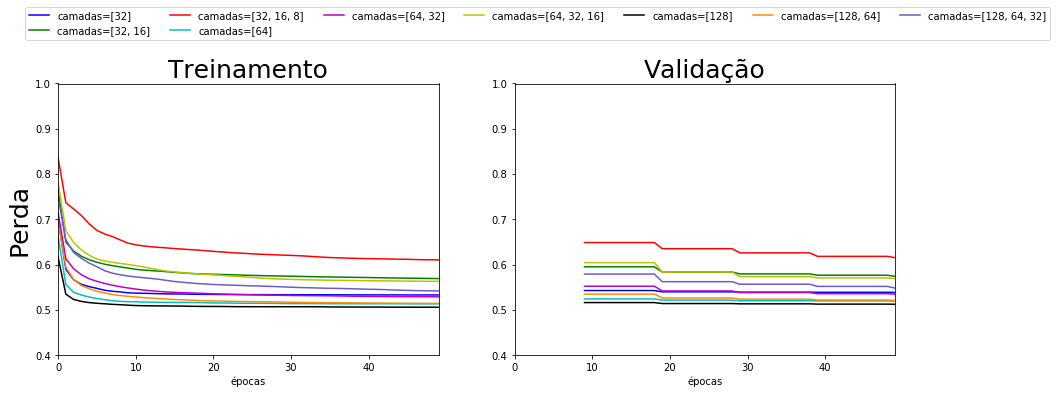

In [28]:
colors = ['b','g','r','c','m','y','k','darkorange', 'slateblue', 'lime', 'tan']
plot_learning_curve(models_results_mnist, params, colors, 'camadas' )

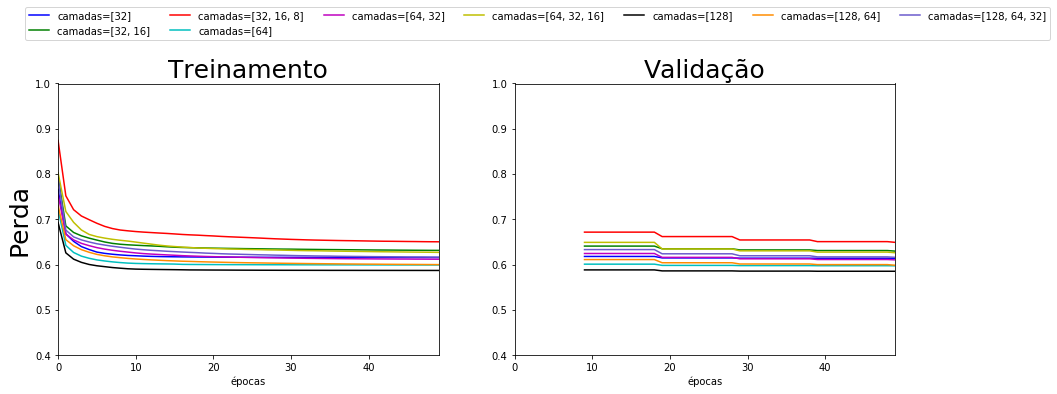

In [29]:
plot_learning_curve(models_results_f_mnist, params, colors, 'camadas' )

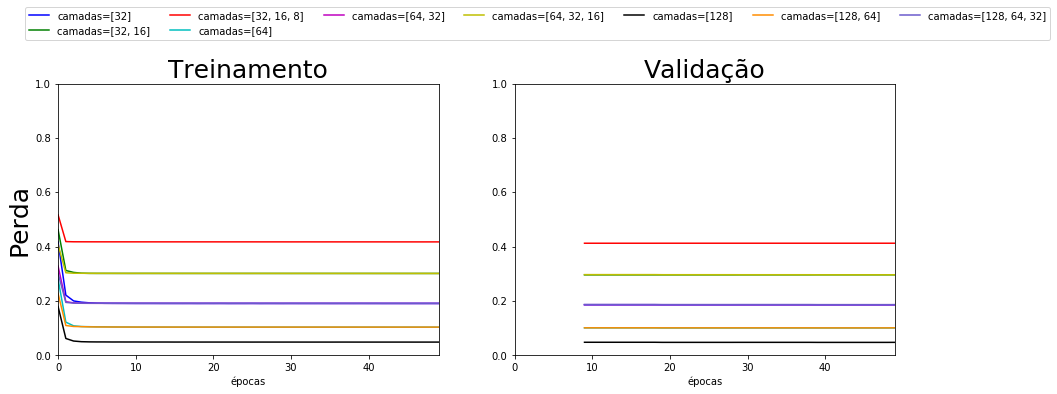

In [34]:
plot_learning_curve(models_results_mnist_linear, params, colors, 'camadas', ylim=[0,1] )

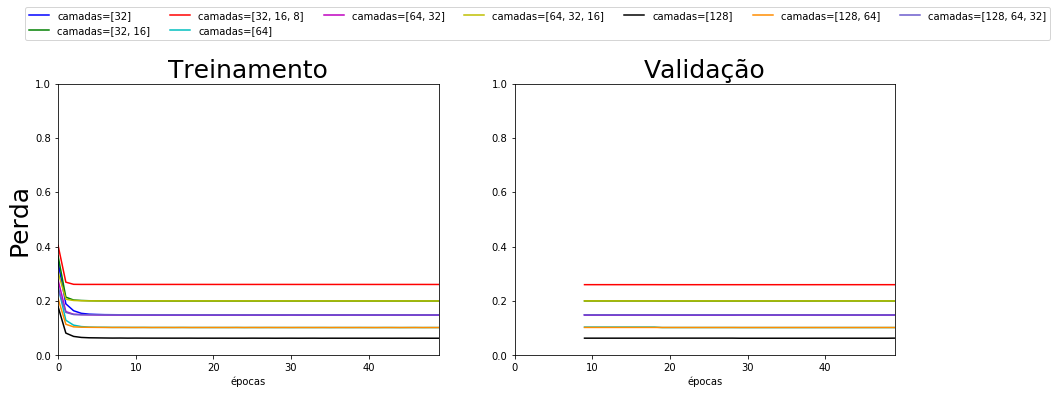

In [35]:
plot_learning_curve(models_results_f_mnist_linear, params, colors, 'camadas', ylim=[0,1] )

A seguir serão apresentados lado a lado a imagem de entrada da rede, a representação gerada pela primeira camada e a saída da rede para cada um dos tipos de experimentos realizados.

Pode ser observado que as saídas geradas pelas redes são bastante similar a entradas, havendo apenas a perda de alguns pequenos detalhes da imagem.

Em relação a codificação da primeira camada, é possivel obeservar que algumas classes apresentaram codificações bastante diferentes (como por exemplo calças e camisas do dataset Fashion MNIST), no entato, é dificil realizar a interpretação desses datos apenas visualmente.

Pode ser notado, atarvés da comparação da codificação das redes com camadas não lineares e redes apenas com camadas lineares, que nas primeras, devido a função de ativação ReLu, a codificação possuem apenas valores positivos, enquanto nas segundas, valores negativos são permitidos.

In [56]:
summary(mnist_best_model, (1,28,28) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 784]         101,136
           Sigmoid-4                  [-1, 784]               0
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.77
Estimated Total Size (MB): 0.79
----------------------------------------------------------------


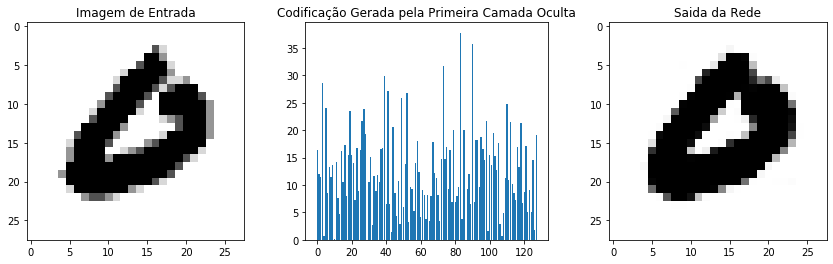

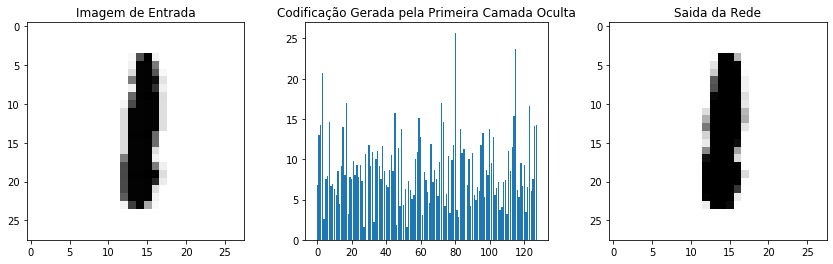

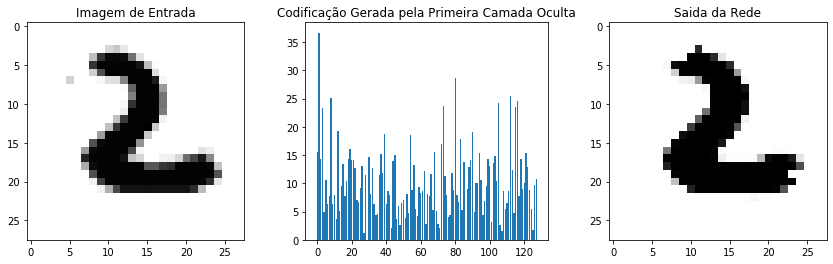

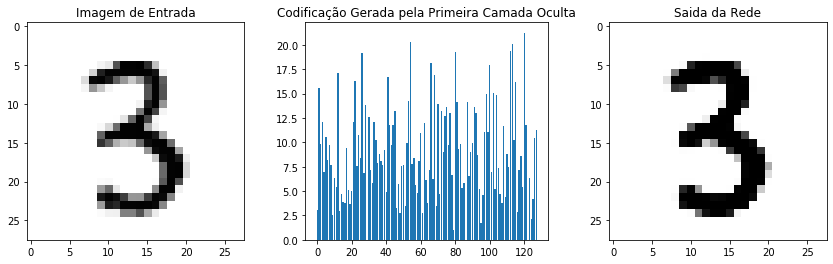

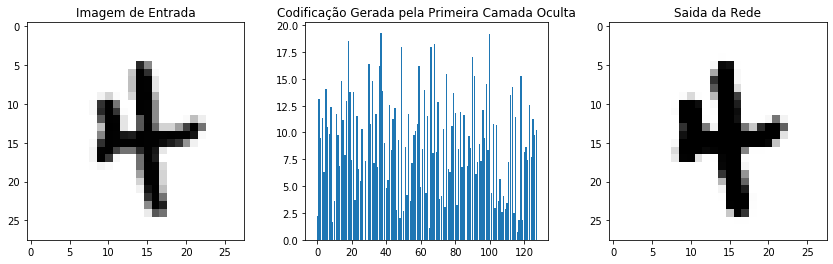

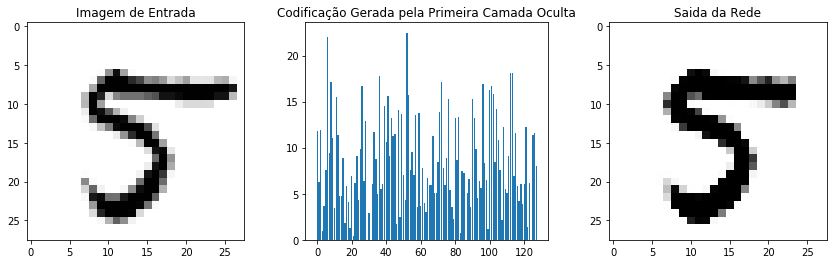

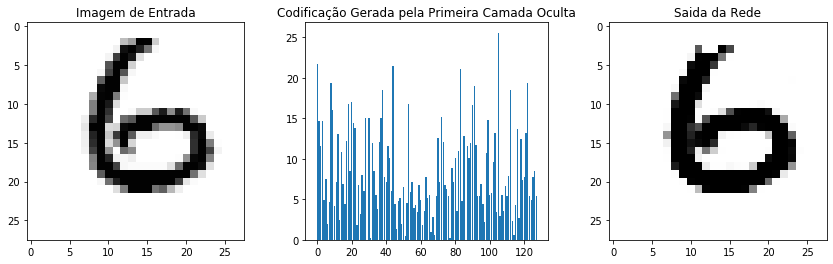

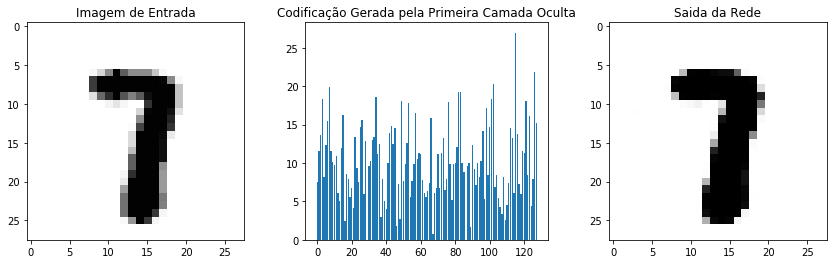

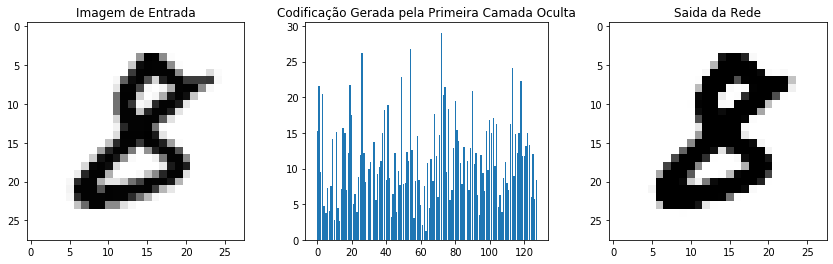

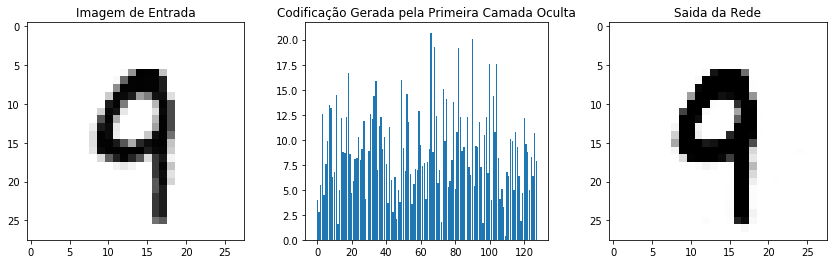

In [44]:
plot_examples_autoencoder( loader_mnist_val, mnist_best_model )

In [57]:
summary(f_mnist_best_model, (1,28,28) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 784]         101,136
           Sigmoid-4                  [-1, 784]               0
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.77
Estimated Total Size (MB): 0.79
----------------------------------------------------------------


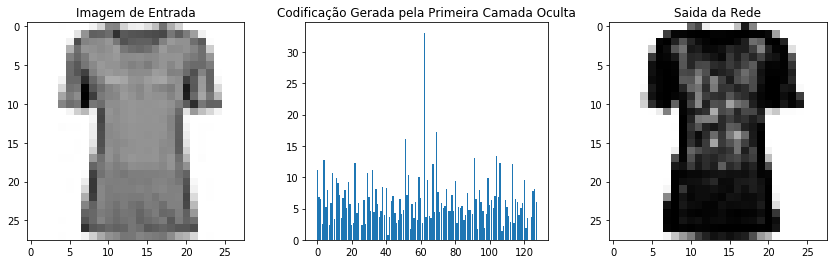

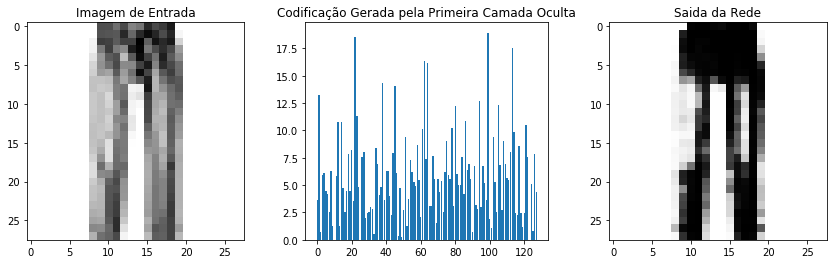

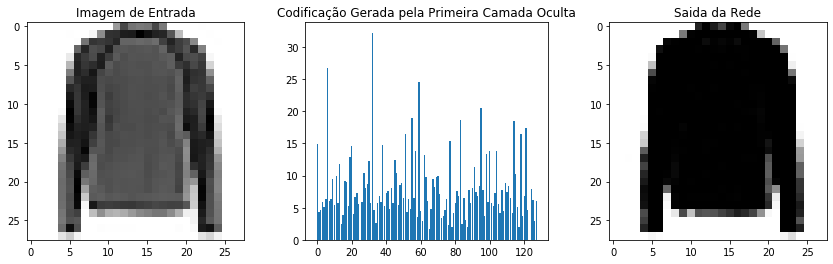

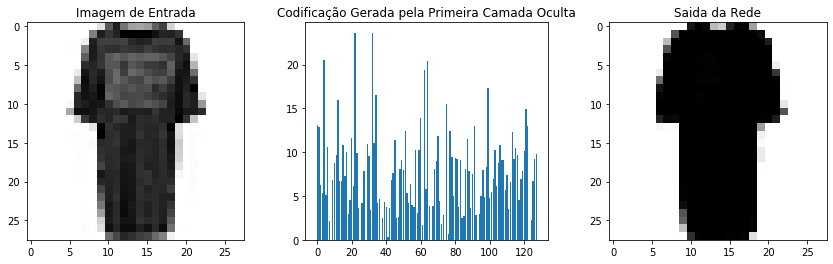

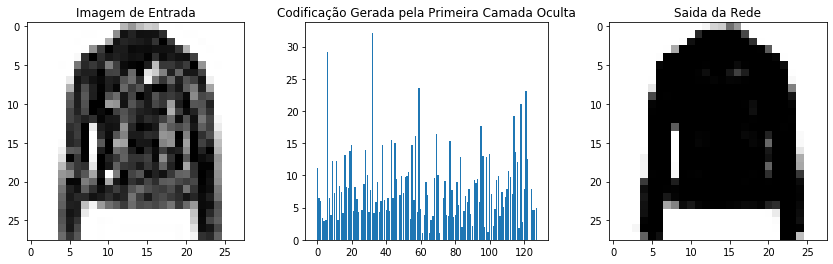

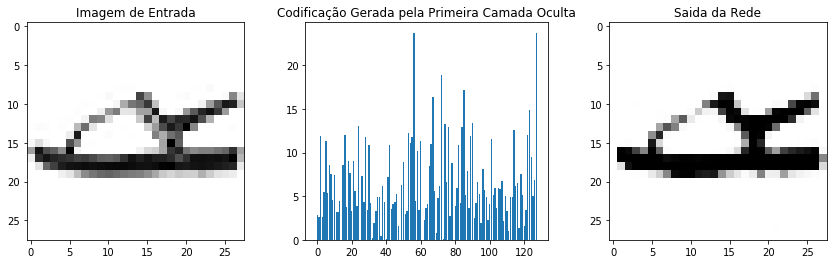

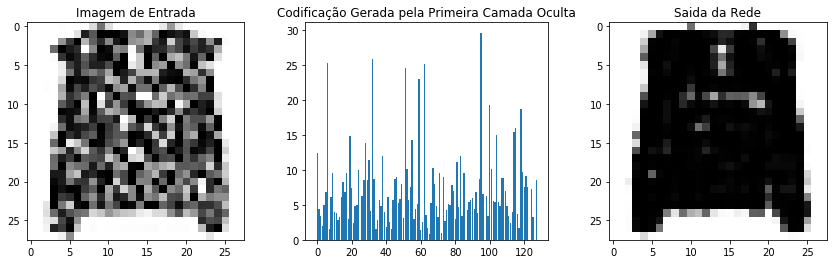

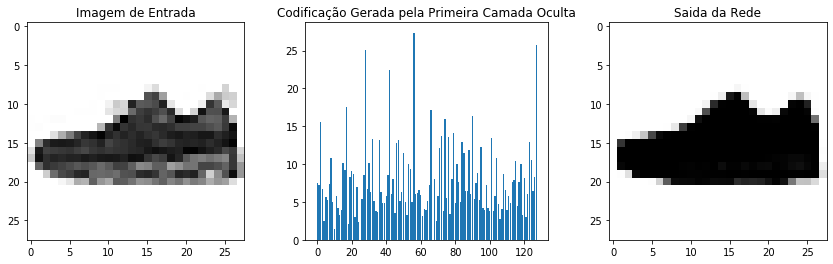

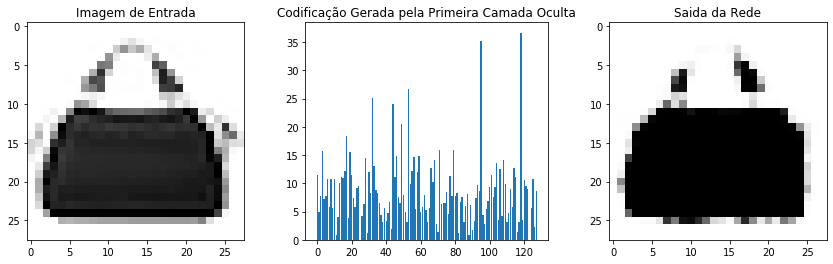

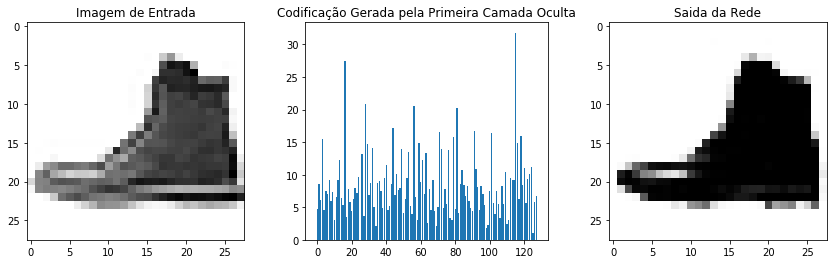

In [48]:
plot_examples_autoencoder( loader_f_mnist_val, f_mnist_best_model )

In [58]:
summary(mnist_best_model_linear, (1,28,28) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
            Linear-2                  [-1, 784]         101,136
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.77
Estimated Total Size (MB): 0.78
----------------------------------------------------------------


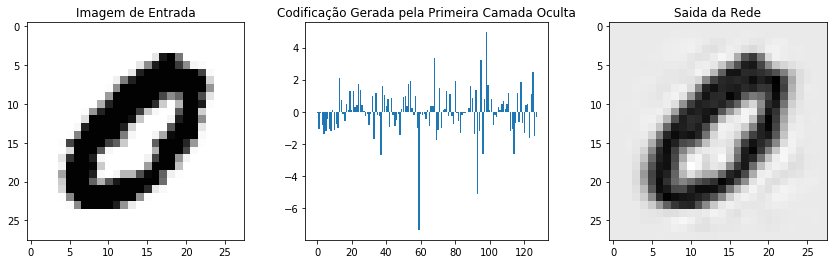

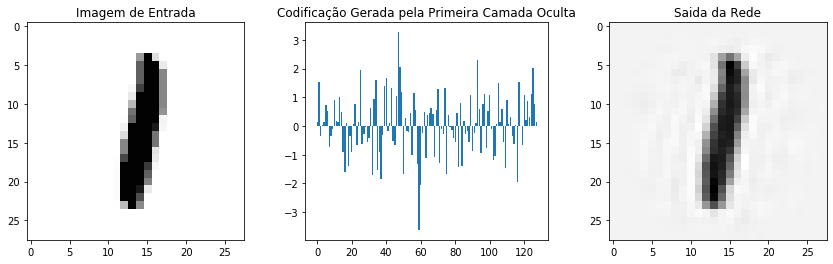

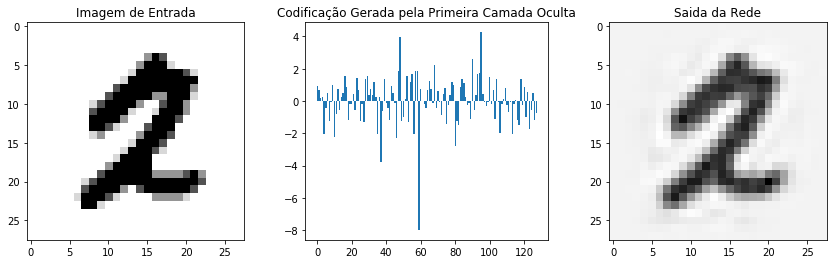

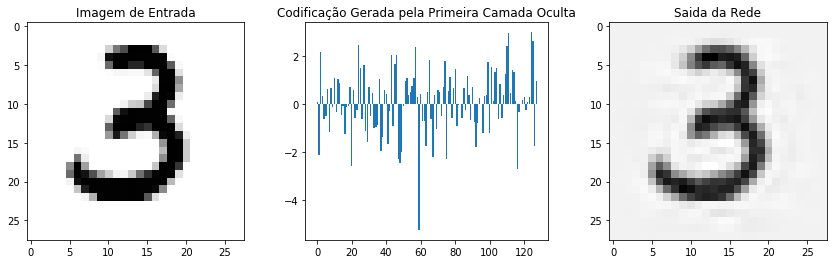

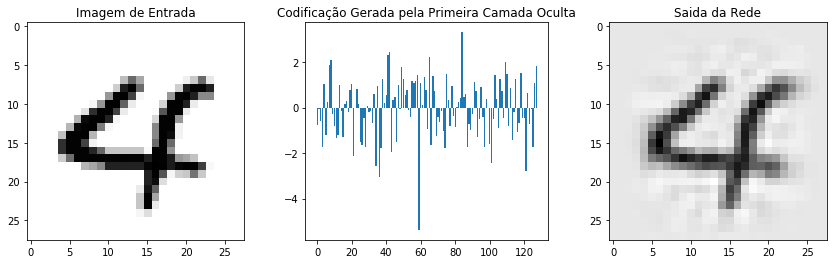

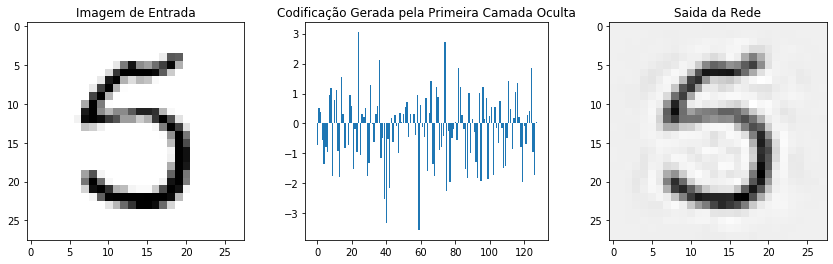

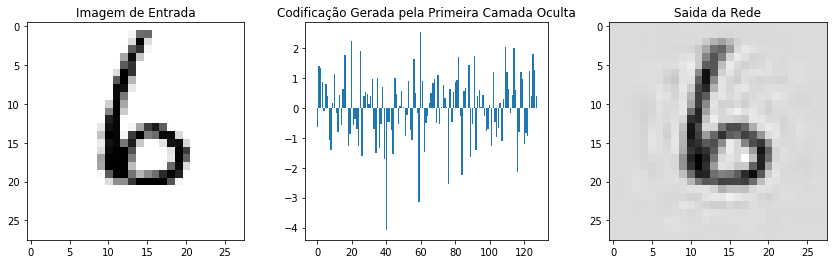

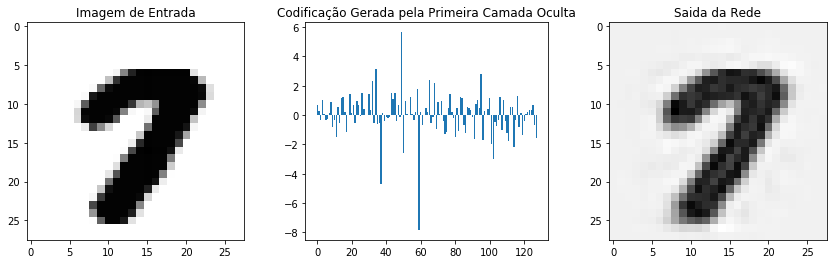

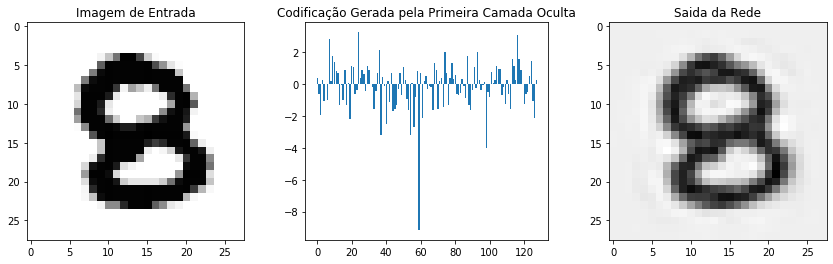

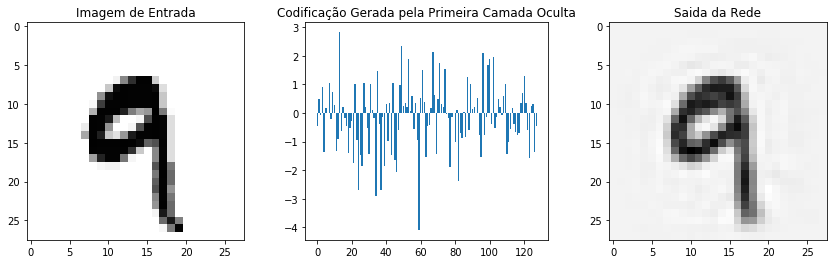

In [53]:
plot_examples_autoencoder( loader_mnist_val, mnist_best_model_linear )

In [59]:
summary(f_mnist_best_model_linear, (1,28,28) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
            Linear-2                  [-1, 784]         101,136
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.77
Estimated Total Size (MB): 0.78
----------------------------------------------------------------


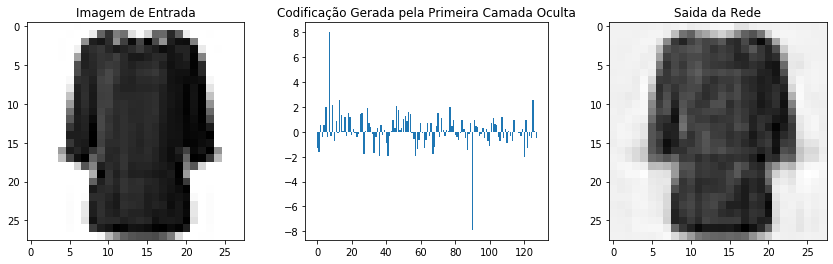

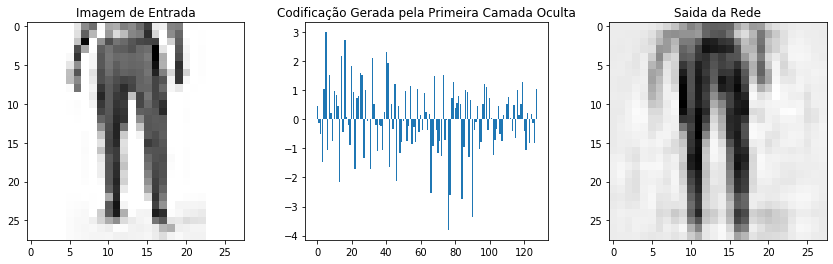

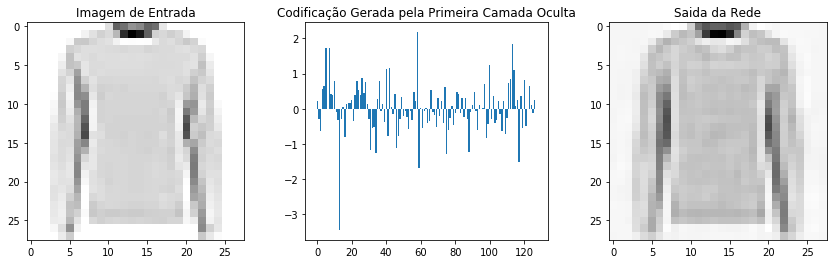

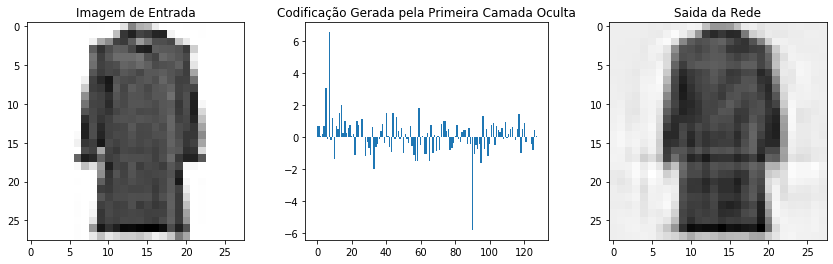

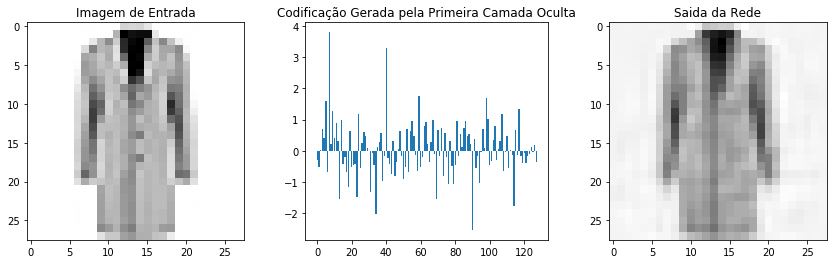

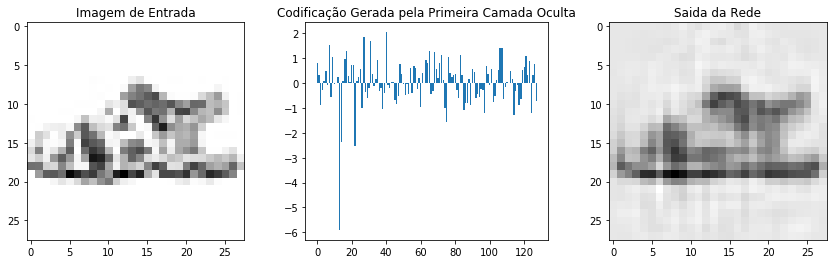

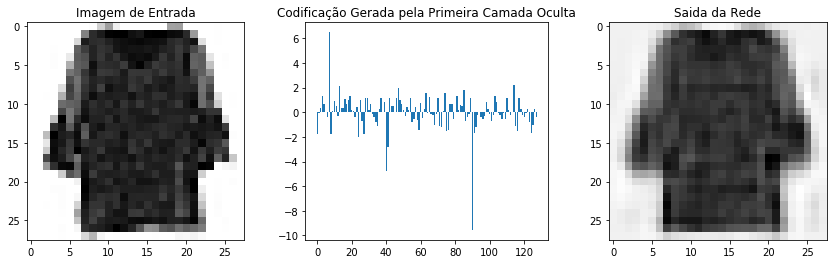

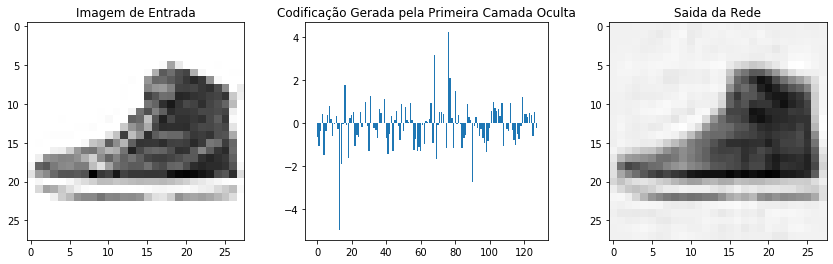

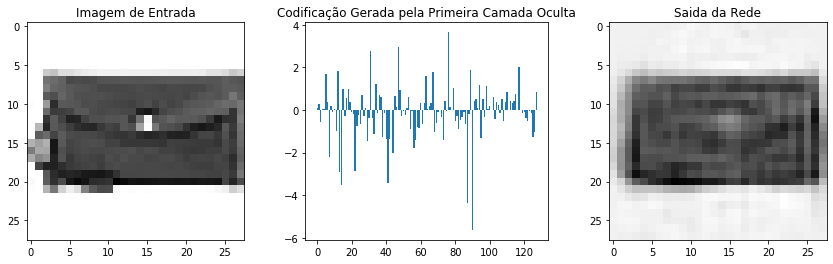

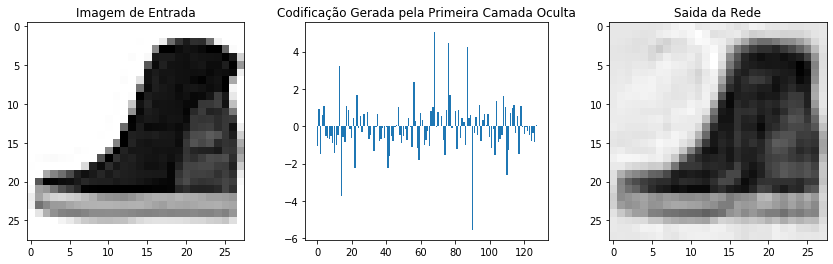

In [54]:
plot_examples_autoencoder( loader_f_mnist_val, f_mnist_best_model_linear )